<a href="https://colab.research.google.com/github/renatossilva/DoctoralThesis/blob/main/trab_Renato_day19only_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and stuff

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [ ]:
from google.colab import drive
file = '/content/drive/'
drive.mount(file)

Mounted at /content/drive/


## Escolher uma pasta: 

In [ ]:
# Drive do Vitor
%cd /content/drive/MyDrive/Trabalho-Renato/

/content/drive/MyDrive/Trabalho-Renato


In [ ]:
# Drive do Renato
%cd /content/drive/My Drive/Tese/AI_tests

/content/drive/My Drive/Tese/AI_tests


# Carregando os dados

## Carregando o dataset do Renato

In [ ]:
file_names = ['Normal_20011207_12-15_full.io', 'CodeRed_20011907_12-15_full.io']
col_names = ['relatorio', 'time', 'BPG_type', 'anomaly', 'AS_peer', 'relevance_peer', 'threat_peer', 'AS_origin', 'relevance', 'relevance_avg', 'relevance_median', 'relevance_max', 'relevance_min', 'threat', 'threat_avg', 'threat_median', 'threat_max', 'threat_min', 'repetitions', 'length', 'origin_type']

df_lst = []
for file in file_names:
  df = pd.read_csv(file, sep='|', names=col_names)
  df_lst.append(df)
df = pd.concat(df_lst, ignore_index=True)

# Ajuste de tipos 
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%y %H:%M:%S')
df['AS_peer'] = pd.to_numeric(df['AS_peer'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Carregando o data set externo

In [ ]:
file_names = ['dataset_CodeRed_513.csv', 'dataset_CodeRed_559.csv', 'dataset_CodeRed_6893.csv']
df_lst = []
for file in file_names:
  df_red = pd.read_csv(file)
  # Pega só o valor númerico (AS_peer) da string do arquivo
  df_red['AS_peer'] = file.split('_')[-1][:-4]
  df_lst.append(df_red)
df_red = pd.concat(df_lst, ignore_index=True)

# Deleta coluna que era apenas um índice
df_red.drop(columns=['Unnamed: 0'], inplace=True)

df_red['timestamp'] = pd.to_datetime(df_red['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_red['AS_peer'] = pd.to_numeric(df_red['AS_peer'])

# Verificando duplicações

In [ ]:
print(f"df original tem: {sum(df.duplicated())} cópias")
print(f"df_red tem: {sum(df_red.duplicated())} cópias")

df original tem: 85043 cópias
df_red tem: 30 cópias


In [ ]:
# df sem cópias
df_unique = df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'records'}).sort_values('time')
df_unique

,relatorio,time,BPG_type,anomaly,AS_peer,relevance_peer,threat_peer,AS_origin,relevance,relevance_avg,relevance_median,relevance_max,relevance_min,threat,threat_avg,threat_median,threat_max,threat_min,repetitions,length,origin_type,records
0,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,11561,0.000014,0.004057,0.000014,0.028571,0.000014,0.000000,1.695605e-06,0.000014,0.028571,0.000014,10,4,0,2
1,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,11960,0.000190,0.011371,0.000302,0.028571,0.000014,0.000000,4.747695e-06,0.000302,0.028571,0.000014,0,5,0,1
2,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,11960,0.000190,0.016621,0.000190,0.071429,0.000014,0.000000,3.744455e-06,0.000190,0.071429,0.000014,0,6,0,1
3,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,1580,0.000086,0.001028,0.000108,0.005208,0.000000,0.000000,1.758475e-07,0.000108,0.005208,0.000000,0,6,2,2
4,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,1580,0.000086,0.002093,0.000302,0.005208,0.000086,0.000000,7.145876e-06,0.000302,0.005208,0.000086,0,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37095,BGP4MP,2001-07-19 15:21:16,A,1,6893,0.000478,0.0,701,0.052632,0.036008,0.000478,0.090909,0.000014,0.000016,4.311825e-06,0.000478,0.090909,0.000014,0,4,0,1
37094,BGP4MP,2001-07-19 15:21:16,A,1,6893,0.000478,0.0,568,0.000014,0.008146,0.000478,0.028571,0.000014,0.000000,1.710806e-06,0.000478,0.028571,0.000014,0,4,0,2
37121,BGP4MP,2001-07-19 15:21:16,A,1,6893,0.000478,0.0,15705,0.000000,0.000508,0.000000,0.003521,0.000000,0.000000,7.505861e-08,0.000000,0.003521,0.000000,2,6,0,1
37107,BGP4MP,2001-07-19 15:21:16,A,1,6893,0.000478,0.0,8342,0.000429,0.100888,0.000478,0.500000,0.000014,0.000479,1.064037e-04,0.000478,0.500000,0.000014,0,5,2,33


In [ ]:
df_unique

,relatorio,time,BPG_type,anomaly,AS_peer,relevance_peer,threat_peer,AS_origin,relevance,relevance_avg,relevance_median,relevance_max,relevance_min,threat,threat_avg,threat_median,threat_max,threat_min,repetitions,length,origin_type,records
0,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,11561,0.000014,0.004057,0.000014,0.028571,0.000014,0.000000,1.695605e-06,0.000014,0.028571,0.000014,10,4,0,2
1,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,11960,0.000190,0.011371,0.000302,0.028571,0.000014,0.000000,4.747695e-06,0.000302,0.028571,0.000014,0,5,0,1
2,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,11960,0.000190,0.016621,0.000190,0.071429,0.000014,0.000000,3.744455e-06,0.000190,0.071429,0.000014,0,6,0,1
3,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,1580,0.000086,0.001028,0.000108,0.005208,0.000000,0.000000,1.758475e-07,0.000108,0.005208,0.000000,0,6,2,2
4,BGP4MP,2001-07-12 12:04:59,A,0,513,0.000302,0.0,1580,0.000086,0.002093,0.000302,0.005208,0.000086,0.000000,7.145876e-06,0.000302,0.005208,0.000086,0,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37095,BGP4MP,2001-07-19 15:21:16,A,1,6893,0.000478,0.0,701,0.052632,0.036008,0.000478,0.090909,0.000014,0.000016,4.311825e-06,0.000478,0.090909,0.000014,0,4,0,1
37094,BGP4MP,2001-07-19 15:21:16,A,1,6893,0.000478,0.0,568,0.000014,0.008146,0.000478,0.028571,0.000014,0.000000,1.710806e-06,0.000478,0.028571,0.000014,0,4,0,2
37121,BGP4MP,2001-07-19 15:21:16,A,1,6893,0.000478,0.0,15705,0.000000,0.000508,0.000000,0.003521,0.000000,0.000000,7.505861e-08,0.000000,0.003521,0.000000,2,6,0,1
37107,BGP4MP,2001-07-19 15:21:16,A,1,6893,0.000478,0.0,8342,0.000429,0.100888,0.000478,0.500000,0.000014,0.000479,1.064037e-04,0.000478,0.500000,0.000014,0,5,2,33


In [ ]:
# df_red sem cópias
df_red_unique = df_red.groupby(df_red.columns.tolist()).size().reset_index().rename(columns={0:'records'})
df_red_unique

,ann_to_longer,ann_to_shorter,announcements,as_path_avg,as_path_max,class,dups,edit_distance_avg,edit_distance_dict_0,edit_distance_dict_1,edit_distance_dict_10,edit_distance_dict_2,edit_distance_dict_3,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_dict_7,edit_distance_dict_8,edit_distance_dict_9,edit_distance_max,edit_distance_unique_dict_0,edit_distance_unique_dict_1,edit_distance_unique_dict_10,edit_distance_unique_dict_2,edit_distance_unique_dict_3,edit_distance_unique_dict_4,edit_distance_unique_dict_5,edit_distance_unique_dict_6,edit_distance_unique_dict_7,edit_distance_unique_dict_8,edit_distance_unique_dict_9,flaps,imp_wd,imp_wd_dpath,imp_wd_spath,nadas,news,nlri_ann,number_rare_ases,origin_0,origin_1,origin_2,origin_changes,rare_ases_avg,rare_ases_max,timestamp,timestamp2,unique_as_path_avg,unique_as_path_max,wd_dups,withdrawals,AS_peer,records
0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,2001-07-17 22:57:50,995410670,0,0,0,0,559,1
1,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,2001-07-18 00:22:50,995415770,0,0,0,0,513,1
2,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,2001-07-18 02:35:50,995423750,0,0,0,0,513,1
3,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,2001-07-18 02:37:50,995423870,0,0,0,0,513,1
4,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,2001-07-18 02:40:50,995424050,0,0,0,0,513,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21373,1752,730,3469,3,22,0,320,1.527682,362,2408,8,256,163,69,65,49,11,42,14,20,362,2408,8,256,163,69,65,49,11,42,14,4,3140,3102,38,4,1,2816,371,652,0,41,27,0.106947,4,2001-07-17 03:10:50,995339450,3,9,0,143,6893,1
21374,1952,11,1987,13,14,0,6,5.196158,6,10,0,4,493,3,4,1457,1,0,0,7,6,10,0,4,493,3,4,1457,1,0,0,0,1968,1968,0,4,9,1982,0,79,1,35,2,0.000000,0,2001-07-18 09:51:50,995449910,10,11,0,23,6893,1
21375,2502,3072,14000,7,15,0,1939,1.882340,2240,1878,1,6945,1834,684,291,59,10,50,6,10,2240,1878,1,6945,1834,684,291,59,10,50,6,225,11662,11591,71,172,2,9921,481,3796,6,329,59,0.034357,3,2001-07-17 08:27:50,995358470,6,10,0,341,513,1
21376,2562,10,4560,4,12,0,434,1.698179,1973,4,0,19,2556,6,0,0,0,1,0,8,1973,4,0,19,2556,6,0,0,0,1,0,0,4122,2583,1539,3,1,2667,8,141,2,59,0,0.001754,1,2001-07-18 09:49:50,995449790,4,9,0,352,559,1


# Fazendo o match entre as tabelas

In [ ]:
# Recebe o dataframe alvo e as informações da linha do df base
# Retorna o index do dataframe alvo que dá match nas informações
# Caso não tenha match retorna -1

def find_line(df_red, as_peer, time, origin_type):
  if origin_type == 0:
    og = 'origin_0'
  elif origin_type == 1:
    og = 'origin_1'
  else:
    og = 'origin_2'
  n_time = time + pd.Timedelta(value=1, unit='m')
  ind = df_red.query('(AS_peer == @as_peer) & ('+ og + ' > 0) & (timestamp >= @time) & (timestamp < @n_time)').index
  if ind.any():
    return ind.item()
  else: 
    return -1

In [ ]:
# Query especificado
q_red = ("(announcements > 0) & "
         "(dups > 0) & "
         "((imp_wd > 0) | (imp_wd_dpath > 0)) & "
         "((news > 0) | (nadas > 0)) & "
         "(origin_changes > 0)")
df_filtered = df_red_unique.query(q_red)
df_unique['key'] = df_unique.apply(lambda row: find_line(df_filtered, 
                                                         row['AS_peer'], 
                                                         row['time'], 
                                                         row['origin_type']), 
                                   axis=1)

# Modelo de aprendizado

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 3.2 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras

import keras_tuner as kt
from keras_tuner import BayesianOptimization

import os
import tempfile

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.figsize'] = (16, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
df_unique['target'] = np.where(df_unique['key'] > -1, 1, 0)

In [ ]:
def classes_prop(df):
  neg, pos = np.bincount(df['target'])
  total = neg + pos
  print('Alvo:\n    Total: {}\n    Positivos: {} ({:.2f}% of total)\n'.format(
      total, pos, 100 * pos / total))

In [ ]:
classes_prop(df_unique)

Alvo:
    Total: 37123
    Positivos: 10172 (27.40% of total)



## Data Prep

Escolha das features e divisão dos dados

In [ ]:
features = ['relevance', 
            'relevance_avg', 
            'relevance_median', 
            'relevance_max', 
            'relevance_min',
            'relevance_peer',
            'threat',
            'threat_avg', 
            'threat_median', 
            'threat_max', 
            'threat_min',
            'threat_peer',
            'repetitions',
            'origin_type',
            'length']
y_label = 'target'

In [ ]:
train = df_unique[(df_unique['time'] > '2001-07-19 00:01:00') & 
                  (df_unique['time'] <= '2001-07-19 14:45:00')]
val = df_unique[(df_unique['time'] > '2001-07-19 14:45:00') & 
                (df_unique['time'] <= '2001-07-19 15:05:00')]
test = df_unique[df_unique['time'] > '2001-07-19 15:05:00']

In [ ]:
total = len(train) + len(val) + len(test) 
prop_tr = (len(train)/total) * 100
prop_v = (len(val)/total) * 100
prop_te = (len(test)/total) * 100

print(f"Treino: {prop_tr:.1f}%\nValidação: {prop_v:.1f}%\nTeste: {prop_te:.1f}%\n")
print("Para o conjunto de treino:")
classes_prop(train)
print(" ")
print("Para o conjunto de validação:")
classes_prop(val)
print(" ")
print("Para o conjunto de teste:")
classes_prop(test)

Treino: 81.6%
Validação: 8.8%
Teste: 9.6%

Para o conjunto de treino:
Alvo:
    Total: 16147
    Positivos: 8261 (51.16% of total)

 
Para o conjunto de validação:
Alvo:
    Total: 1744
    Positivos: 858 (49.20% of total)

 
Para o conjunto de teste:
Alvo:
    Total: 1907
    Positivos: 1053 (55.22% of total)



In [ ]:
X_train = train[features]
y_train = np.array(train[y_label])

X_val = val[features]
y_val = np.array(val[y_label])

X_test = test[features]
y_test = np.array(test[y_label])

Scaling [-1, 1]

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
print('Curva de rótulos de treinamento:', y_train.shape)
print('Curva de rótulos de validação:', y_val.shape)
print('Curva de rótulos de teste:', y_test.shape)
print()
print('Curva de atributos de treinamento:', X_train.shape)
print('Curva de atributos de validação:', X_val.shape)
print('Curva de atributos de teste:', X_test.shape)

Curva de rótulos de treinamento: (16147,)
Curva de rótulos de validação: (1744,)
Curva de rótulos de teste: (1907,)

Curva de atributos de treinamento: (16147, 15)
Curva de atributos de validação: (1744, 15)
Curva de atributos de teste: (1907, 15)


## Training

Definindo o modelo

In [ ]:
def model_builder(hp):
  METRICS = [keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR')]

  # Hyperparameters ranges
  dense_outer = hp.Int('units_outer', min_value=16, max_value=128, step=16)
  dense_inner = hp.Int('units_inner', min_value=16, max_value=128, step=16)
  dense_act = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'],
                         default='relu')
  dropout_outer = hp.Choice('dropout_outer', values=[0.1, 0.2, 0.3, 0.4, 0.5])
  dropout_inner = hp.Choice('dropout_inner', values=[0.1, 0.2, 0.3, 0.4, 0.5])
  l_rate = hp.Choice('learning_rate', 
                     values = [1e-2, 1.5e-2, 1e-3, 1.5e-3, 1e-4, 1.5e-4])

  model = keras.Sequential([keras.layers.Dense(dense_outer, 
                                               activation=dense_act,
                                               input_shape=(X_train.shape[-1],)),
                            keras.layers.Dropout(dropout_outer),
                            keras.layers.Dense(dense_inner, 
                                               activation=dense_act),
                            keras.layers.Dropout(dropout_inner),
                            keras.layers.Dense(1,
                                               activation='sigmoid')])
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=l_rate),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

  return model

Criando/Treinando o modelo

In [ ]:
EPOCHS = 100
BATCH_SIZE = 128

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=15,
    mode='min',
    restore_best_weights=True)

In [ ]:
bayesian_tuner = BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=20,
    seed=10,
    project_name='day19only',
    overwrite=True)

In [ ]:
bayesian_tuner.search(X_train,
             y_train,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             callbacks=[early_stopping],
             validation_data=(X_val, y_val),
             verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00029: early s

In [ ]:
best_hps=bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Melhores valores:

Dense Units 
    Outer: {best_hps.get('units_outer')}
    Inner: {best_hps.get('units_inner')}

Dense Activation: {best_hps.get('dense_activation')}

Dropout %
    Outer: {best_hps.get('dropout_outer')}
    Inner: {best_hps.get('dropout_inner')}

Learning Rate: {best_hps.get('learning_rate')}
""")



Melhores valores:

Dense Units 
    Outer: 112
    Inner: 128

Dense Activation: relu

Dropout %
    Outer: 0.1
    Inner: 0.1

Learning Rate: 0.01



Treinando o melhor modelo

In [ ]:
model = bayesian_tuner.hypermodel.build(best_hps)
baseline_history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))

Epoch 1/100
127/127 [==============================] - 4s 12ms/step - loss: 0.6560 - tp: 6947.0000 - fp: 4953.0000 - tn: 2933.0000 - fn: 1314.0000 - accuracy: 0.6119 - precision: 0.5838 - recall: 0.8409 - auc: 0.6244 - prc: 0.5885 - val_loss: 0.5939 - val_tp: 856.0000 - val_fp: 571.0000 - val_tn: 315.0000 - val_fn: 2.0000 - val_accuracy: 0.6714 - val_precision: 0.5999 - val_recall: 0.9977 - val_auc: 0.6753 - val_prc: 0.5903
Epoch 2/100
127/127 [==============================] - 0s 4ms/step - loss: 0.6440 - tp: 6963.0000 - fp: 4642.0000 - tn: 3244.0000 - fn: 1298.0000 - accuracy: 0.6321 - precision: 0.6000 - recall: 0.8429 - auc: 0.6522 - prc: 0.6096 - val_loss: 0.6262 - val_tp: 651.0000 - val_fp: 442.0000 - val_tn: 444.0000 - val_fn: 207.0000 - val_accuracy: 0.6279 - val_precision: 0.5956 - val_recall: 0.7587 - val_auc: 0.6554 - val_prc: 0.5714
Epoch 3/100
127/127 [==============================] - 0s 4ms/step - loss: 0.6355 - tp: 6681.0000 - fp: 4184.0000 - tn: 3702.0000 - fn: 1580.00

## Resultados


Def. Plots

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Treinamento')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Validação')
    plt.xlabel('Rodada', fontsize = 18)
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label', fontsize = 18)
  plt.xlabel('Predicted label', fontsize = 18)

  print('Verdadeiro-negativos: ', cm[0][0])
  print('Falso-positivos: ', cm[0][1])
  print('Falso-negativos: ', cm[1][0])
  print('Verdadeiro-positivos: ', cm[1][1])
  print('Total: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('FPR [%]', fontsize = 18)
  plt.ylabel('TPR [%]', fontsize = 18)
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('TPR (Recall)', fontsize = 18)
    plt.ylabel('PPV (Precision)', fontsize = 18)
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

Plots

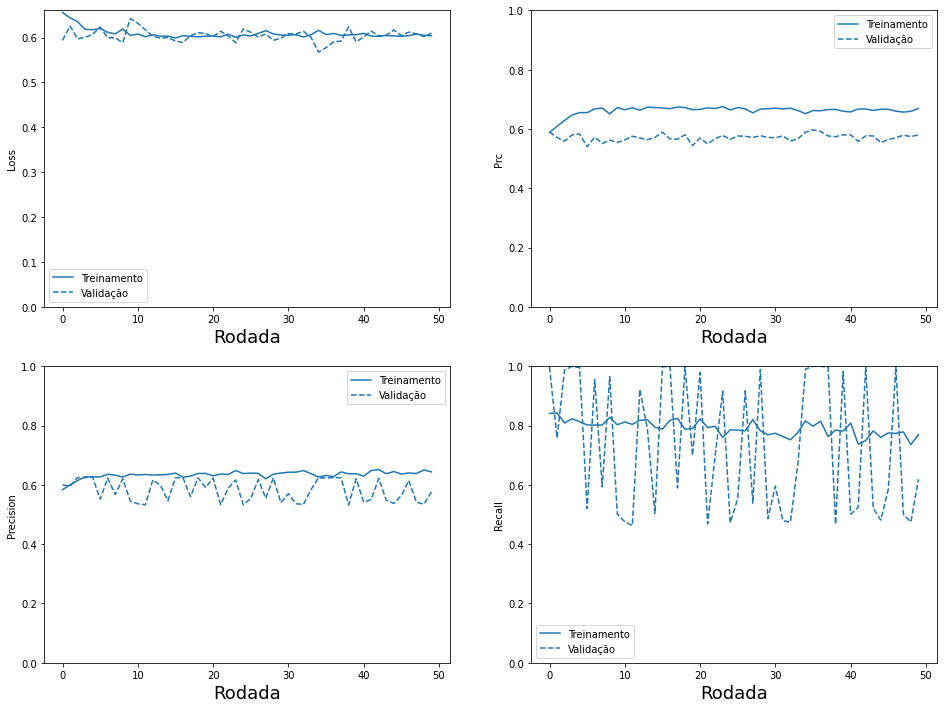

In [ ]:
plot_metrics(baseline_history)

Matriz de confusão

loss :  0.5563344955444336
tp :  1003.0
fp :  485.0
tn :  369.0
fn :  50.0
accuracy :  0.7194546461105347
precision :  0.6740591526031494
recall :  0.9525166153907776
auc :  0.7527350187301636
prc :  0.7722299695014954

Verdadeiro-negativos:  369
Falso-positivos:  485
Falso-negativos:  50
Verdadeiro-positivos:  1003
Total:  1053


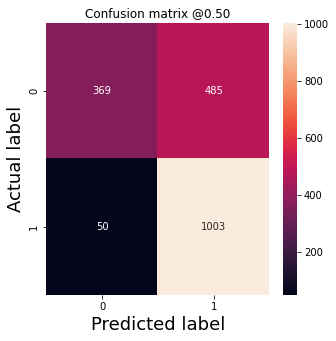

In [ ]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

ROC

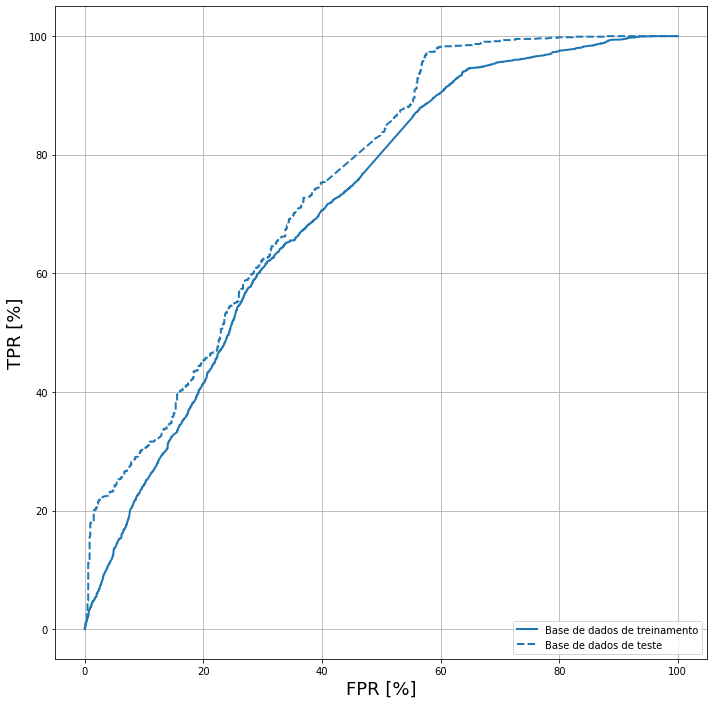

In [ ]:
plot_roc("Base de dados de treinamento", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Base de dados de teste", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

PRC

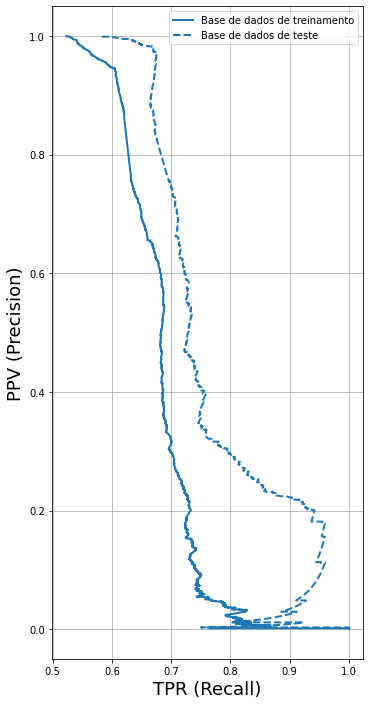

In [ ]:
plot_prc("Base de dados de treinamento", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Base de dados de teste", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='upper right')